In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import numpy as np
import pandas as pd
from itertools import product
from IPython.display import display, Markdown, Latex

# Question 1 - Line Drawing Interpretation
## Section b

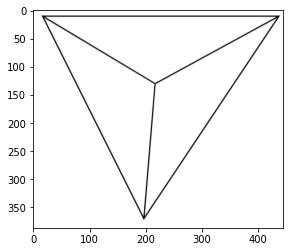

In [2]:
img = cv2.imread('Relax.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [69]:
def show_confidence(confidence,nObjects,nLabels):
    pd.set_option('display.latex.repr', True)
    return pd.DataFrame(confidence,
                        columns=[f'b={i+1}' for i in range(nObjects)], #The columns are the objects
                        index = [f'𝜆={i + 1}' for i in range(nLabels)]) #The rows are the labels

nObjects = 4
nLabels = 16
# Initialize the confidence matrix 
confidence = np.zeros((nLabels, nObjects))
# Set the initial confidence (confidence at iteration 0)
confidence[9:12, 0] = (1 / 3)
confidence[9:12, 1] = (1 / 3)
confidence[9:12, 2] = (1 / 3)
confidence[6:9, 3] = (1 / 3)
# Display the initial confidence matrix
show_confidence(confidence,nObjects,nLabels)

,b=1,b=2,b=3,b=4
𝜆=1,0.000000,0.000000,0.000000,0.000000
𝜆=2,0.000000,0.000000,0.000000,0.000000
𝜆=3,0.000000,0.000000,0.000000,0.000000
𝜆=4,0.000000,0.000000,0.000000,0.000000
𝜆=5,0.000000,0.000000,0.000000,0.000000
𝜆=6,0.000000,0.000000,0.000000,0.000000
𝜆=7,0.000000,0.000000,0.000000,0.333333
𝜆=8,0.000000,0.000000,0.000000,0.333333
𝜆=9,0.000000,0.000000,0.000000,0.333333
𝜆=10,0.333333,0.333333,0.333333,0.000000


In [70]:
# Initialize the compatibility function dictionary
comp = {}
# Fill in the dictionary: 
# the keys are tuples of objects (i,j)
# the values are lists of tuples of labels [(𝜆1,𝜆2),...,(𝜆10,𝜆11)]
comp[(1, 1)] = [(l, l) for l in [10,11,12]]
comp[(1, 2)] = [(10, 10),(11, 11),(12, 12)]
comp[(1, 3)] = [(10, 10),(11, 11),(12, 12)]
comp[(1, 4)] = [(12, 9),(10, 8),(11, 8),(12, 7)]
comp[(2, 1)] = [(l2, l1) for (l1, l2) in comp[(1, 2)]]
comp[(2, 2)] = [(l, l) for l in [10,11,12]]
comp[(2, 3)] = [(10, 10),(11, 11),(12, 12)]
comp[(2, 4)] = [(12, 9),(10, 8),(11, 8),(12, 7)]
comp[(3, 1)] = [(l2, l1) for (l1, l2) in comp[(1, 3)]]
comp[(3, 2)] = [(l2, l1) for (l1, l2) in comp[(2, 3)]]
comp[(3, 3)] = [(l, l) for l in [10,11,12]]
comp[(3, 4)] = [(12, 9),(10, 8),(11, 8),(12, 7)]
comp[(4, 1)] = [(l2, l1) for (l1, l2) in comp[(1, 4)]]
comp[(4, 2)] = [(l2, l1) for (l1, l2) in comp[(2, 4)]]
comp[(4, 3)] = [(l2, l1) for (l1, l2) in comp[(3, 4)]]
comp[(4, 4)] = [(l, l) for l in [7,8,9]]

# Display the compatibility dictionary
comp

{(1, 1): [(10, 10), (11, 11), (12, 12)],
 (1, 2): [(10, 10), (11, 11), (12, 12)],
 (1, 3): [(10, 10), (11, 11), (12, 12)],
 (1, 4): [(12, 9), (10, 8), (11, 8), (12, 7)],
 (2, 1): [(10, 10), (11, 11), (12, 12)],
 (2, 2): [(10, 10), (11, 11), (12, 12)],
 (2, 3): [(10, 10), (11, 11), (12, 12)],
 (2, 4): [(12, 9), (10, 8), (11, 8), (12, 7)],
 (3, 1): [(10, 10), (11, 11), (12, 12)],
 (3, 2): [(10, 10), (11, 11), (12, 12)],
 (3, 3): [(10, 10), (11, 11), (12, 12)],
 (3, 4): [(12, 9), (10, 8), (11, 8), (12, 7)],
 (4, 1): [(9, 12), (8, 10), (8, 11), (7, 12)],
 (4, 2): [(9, 12), (8, 10), (8, 11), (7, 12)],
 (4, 3): [(9, 12), (8, 10), (8, 11), (7, 12)],
 (4, 4): [(7, 7), (8, 8), (9, 9)]}

In [71]:
# The standard support function:
def support(obj,label,comp,confidence):
  temp = [confidence[mu-1,j-1] for i,j in comp if i==obj
          for lm,mu in comp[(i,j)] if lm==label]
  return sum(temp)

# The confidence update rule:
def update(curr_confidence, comp):
  nLabels, nObjects = curr_confidence.shape
  res = np.zeros_like(curr_confidence)
  for obj in range(nObjects):
    res[:, obj] = [support(obj+1, label+1, comp, curr_confidence) 
                    for label in range(nLabels)]
    res[:, obj] = res[:, obj] / res[:, obj].sum()
  return res

# The average local consistency:
def average_local_consistency(confidence, comp):
    nLabels, nObjects = confidence.shape
    return sum(confidence[(label, obj)] * support(obj + 1, label + 1, comp, confidence)
               for obj, label in product(range(nObjects), range(nLabels)))

In [72]:
# The relaxation labeling algorithm:
def relaxationLabeling(initial_confidence,comp,epsilon):
  curr_it = initial_confidence
  avg_local_cons = []
  k = 0
  while True:
      avg_local_cons.append(average_local_consistency(curr_it, comp))
      next_it = update(curr_it, comp)
      diff = abs(average_local_consistency(curr_it, comp) - 
                 average_local_consistency(next_it, comp))
      display(Markdown(r'$|A(\bar{{ p^{{ {} }}  }}) - A(\bar{{p^{{ {}  }}}})| = {}$'.format(k + 1, k, diff)))
      curr_it = next_it
      k = k + 1
      if diff < epsilon:
          break
  return next_it, avg_local_cons

In [73]:
#Use RL to find consistent labeling
final_confidence, avg_local_cons = relaxationLabeling(confidence,comp,epsilon=0.001)

$|A(\bar{ p^{ 1 }  }) - A(\bar{p^{ 0  }})| = 0.3493491124260357$

$|A(\bar{ p^{ 2 }  }) - A(\bar{p^{ 1  }})| = 0.04461556915589959$

$|A(\bar{ p^{ 3 }  }) - A(\bar{p^{ 2  }})| = 0.005878442218069324$

$|A(\bar{ p^{ 4 }  }) - A(\bar{p^{ 3  }})| = 0.0007711437196924464$

In [74]:
# Display the final confidence matrix
show_confidence(final_confidence,nObjects,nLabels)

,b=1,b=2,b=3,b=4
𝜆=1,0.000000,0.000000,0.000000,0.000000
𝜆=2,0.000000,0.000000,0.000000,0.000000
𝜆=3,0.000000,0.000000,0.000000,0.000000
𝜆=4,0.000000,0.000000,0.000000,0.000000
𝜆=5,0.000000,0.000000,0.000000,0.000000
𝜆=6,0.000000,0.000000,0.000000,0.000000
𝜆=7,0.000000,0.000000,0.000000,0.274604
𝜆=8,0.000000,0.000000,0.000000,0.450792
𝜆=9,0.000000,0.000000,0.000000,0.274604
𝜆=10,0.310745,0.310745,0.310745,0.000000


In [75]:
# Display the final consistent labeling we found:
def show_consistent_labeling(final_confidence):
  b1 = np.argmax(final_confidence[:,0])+1
  b2 = np.argmax(final_confidence[:,1])+1
  b3 = np.argmax(final_confidence[:,2])+1
  b4 = np.argmax(final_confidence[:,3])+1
  print(f'Consistent labeling {{b1={b1},b2={b2},b3={b3},b4={b4}}}')

show_consistent_labeling(final_confidence)

Consistent labeling {b1=12,b2=12,b3=12,b4=8}


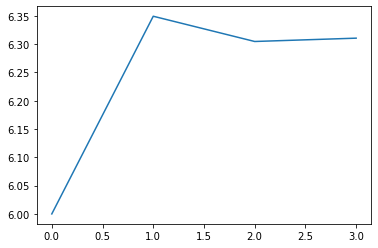

In [76]:
plt.plot(avg_local_cons)